## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any, Callable, List

In [2]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
!pwd

/home/xavi/Documents/CreditRisk/notebooks


In [4]:
file: Path = Path('/home/xavi/Documents/CreditRisk/data/curated/dataset.parquet')

In [5]:
df: pd.DataFrame = pd.read_parquet(file, engine='pyarrow')

### Depedent variable:

In [6]:
df['loan_status'].value_counts(dropna=False, normalize=True)

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64

In [7]:
defaults: List[str] = [
    'Charged Off',
    'Late (31-120 days)',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

In [8]:
is_in_defaults: Callable  = defaults.__contains__

In [9]:
df['non_default'] = df['loan_status'].apply(lambda v: 0 if is_in_defaults(v) else 1)

In [10]:
df['zip_code'].dtype

dtype('int16')

### Indepent variables

#### Discrete variables

In [11]:
category_mask: pd.Series = df.dtypes == 'category'

In [12]:
categories: List[str] = df.dtypes[category_mask].index.to_list()

In [13]:
cat_df: pd.DataFrame = df[categories + ['non_default']].drop('issue_d', axis=1)

In [14]:
categories.remove('issue_d')
categories.remove('loan_status')

In [15]:
categories

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'policy_code',
 'application_type']

**WoE and IV calculation**:

In [16]:
def calculate_woe_iv(data:pd.DataFrame, variable:pd.Series, target:pd.Series, multilevel_index:bool = False, aggfunc: Callable = len) -> pd.DataFrame:
    pivot = pd.pivot_table(data=data, index=variable, columns=target, aggfunc=aggfunc, fill_value=0, values=[])
    pivot['n_obs'] = pivot.apply(axis=1, func=np.sum)
    pivot['n_obs_rel'] = pivot['n_obs'] / pivot['n_obs'].sum()

    #add .00000005 to handle errors when calculating WoE (ln(0))
    pivot['bad_rel'] = (pivot[0] + .00000005) / pivot[0].sum()
    pivot['good_rel'] = (pivot[1] + .00000005) / pivot[1].sum()

    pivot['woe'] = np.log(pivot['good_rel']) - np.log(pivot['bad_rel'])

    pivot = pivot.sort_values(by='woe', ascending=True)
    pivot['good_rel_diff'] = pivot['good_rel'].diff().abs()
    pivot['bad_rel_diff'] = pivot['bad_rel'].diff().abs()
    pivot['woe_diff'] = pivot['woe'].diff().abs()
    pivot['accum_n_obs_rel'] = pivot['n_obs_rel'].cumsum()
    
    pivot['iv'] = ((pivot['good_rel'] - pivot['bad_rel']) * pivot['woe']).sum()
    
    if multilevel_index:
        pivot['variable'] = variable.name
        pivot = pivot.set_index(['variable', pivot.index])

    return pivot.sort_values(by='woe', ascending=True)

In [17]:
def run_woe_iv(data:pd.DataFrame, independent_vars:List[str], dependent_var:str) -> pd.DataFrame:
    accum: pd.Dataframe = pd.DataFrame([])
    for v in independent_vars:
        result = calculate_woe_iv(data[[v, dependent_var]], data[v], data[dependent_var], multilevel_index=True)
        accum = pd.concat([accum, result], axis=0)

    return accum

In [18]:
calculate_woe_iv(cat_df, cat_df['grade'], cat_df['non_default'], multilevel_index=True)

non_default         0       1   n_obs  n_obs_rel   bad_rel  good_rel  \
variable grade                                                         
grade    G        924    2398    3322   0.007124  0.018129  0.005774   
         F       3192   10037   13229   0.028371  0.062628  0.024167   
         E       6964   28793   35757   0.076685  0.136635  0.069328   
         D      11848   65040   76888   0.164895  0.232460  0.156603   
         C      14384  110909  125293   0.268705  0.282216  0.267047   
         B      10759  126170  136929   0.293659  0.211093  0.303792   
         A       2897   71970   74867   0.160561  0.056840  0.173289   

non_default          woe  good_rel_diff  bad_rel_diff  woe_diff  \
variable grade                                                    
grade    G     -1.144166            NaN           NaN       NaN   
         F     -0.952214       0.018393      0.044499  0.191952   
         E     -0.678466       0.045161      0.074007  0.273748   
         D     -0.395001       0.087276      0.095825  0.283465   
         C     -0.055251       0.110443      0.049757  0.339750   
         B      0.364043       0.036745      0.071123  0.419294   
         A      1.114730       0.130503      0.154254  0.750686   

non_default     accum_n_obs_rel        iv  
variable grade                             
grade    G             0.007124  0.290782  
         F             0.035495  0.290782  
         E             0.112180  0.290782  
         D             0.277075  0.290782  
         C             0.545780  0.290782  
         B             0.839439  0.290782  
         A             1.000000  0.290782

In [19]:
woe_summary = run_woe_iv(data=cat_df, independent_vars=categories, dependent_var='non_default')

In [20]:
woe_summary.groupby(level=0)['iv'].max().sort_values(ascending=False).apply(lambda v: '{0}'.format(str(v)))

variable
sub_grade                 0.31518048388061826
grade                     0.29078213954153515
term                       0.0388598343886394
purpose                   0.03698019472315489
initial_list_status      0.024801321308154253
home_ownership            0.02169733320858703
verification_status      0.020831404234464192
addr_state               0.012672623763957586
emp_length              0.0048260242100888395
pymnt_plan             0.00012456255520646649
application_type        7.407096244268185e-25
policy_code             7.407096244268185e-25
Name: iv, dtype: object

**Plot WoE**:

In [21]:
def plot_woe(woe_series: pd.Series, labels: pd.Series | None = None):
    fig = plt.figure(figsize=(18, 6))

    style_dict = {
                  'xlabel': 'Categories',
                  'title': '{0}'.format(woe_series.name),
                 }
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    ax.plot(woe_series.index, woe_series.values, color='red', marker='o', linestyle='--')

    if labels is not None:
        for (i, label), value in zip(enumerate(labels.values), woe_series.values) :
            ax.text(i, value + 0.1, label)
    
    return ax

<Axes: title={'center': 'woe'}, xlabel='Categories'>

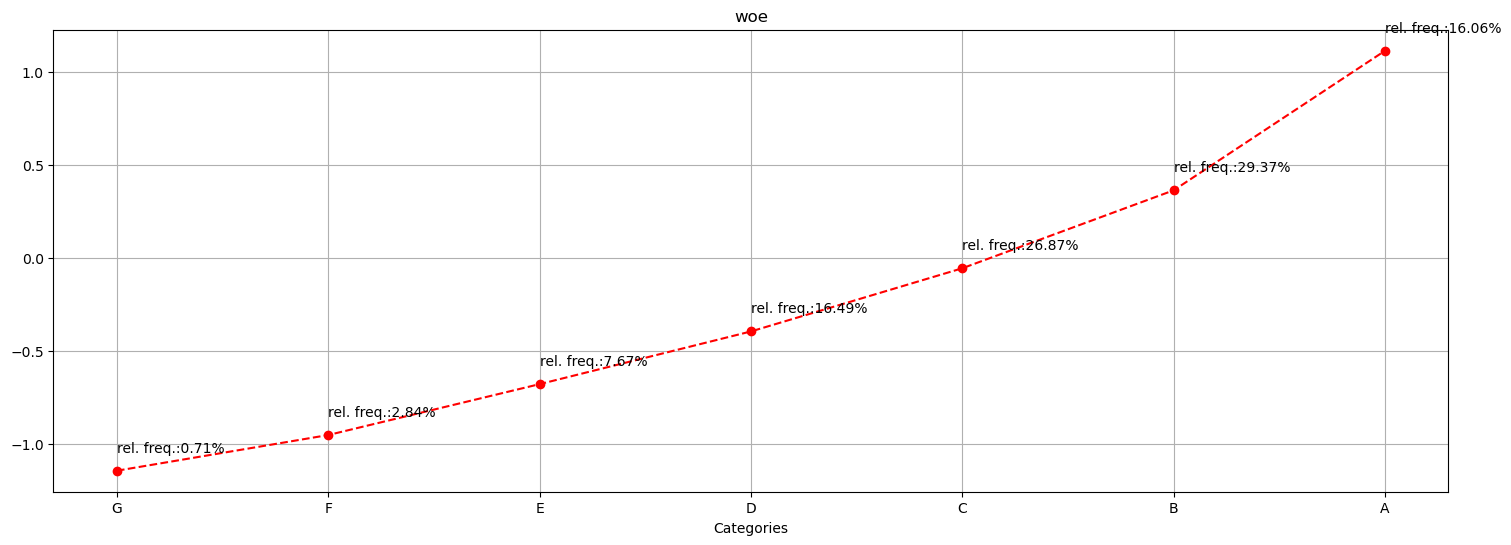

In [22]:
plot_woe(woe_summary.loc['grade', :]['woe'], labels=woe_summary.loc['grade', :]['n_obs_rel'].apply(lambda v: 'rel. freq.:{0:.2%}'.format(v)))

**Category-grouping tools**:

In [1025]:
from collections.abc import Iterable
import abc

class Component(Iterable, abc.ABC):

    def __init__(self, *args, **kwargs):
        self.children = list()
        self._name: str = ''
    
    def add_child(self, element) -> 'Component':
        self.children.append(element)

        return self
        
    def remove_child(self, element) -> 'Component':
        self.children.append(element)

        return self

    def _str_leaves(self, indent: int = 0) -> str:
        initial_str: str = '| ' * indent + f'|----{self.name}\n'
        for element in self:
            if isinstance(element, Component):
                initial_str += element._str_leaves(indent + 1)

            else:
                initial_str += '| ' * (indent + 1) + f'|----{str(element)}\n'

        return initial_str
        
    @abc.abstractmethod
    def transform(self, *args, **kwargs) -> Any: pass

    @abc.abstractproperty
    def name(self) -> str: pass

    def __str__(self) -> str:
        return self._str_leaves(indent=0)


class Group(Component):

    def transform(self) -> Callable:
        return self.children.__contains__

    @property
    def name(self):
        return '_'.join(map(str, self.children))

    def extend_group(self, elements) -> Component:
        self.children.extend(elements)

        return self

    def __iter__(self):
        for value in self.children:
            yield value


class GroupedColumn(Group):

    def __init__(self, name: str, *args, **kwargs):
        Component.__init__(self, *args, **kwargs)
        self._name = name

    def transform(self, series: pd.Series) -> pd.DataFrame:
        df_dict: dict[str, pd.Series] = {}
        for group in self:
            df_dict[self.name + '_' + str(group)] = series.apply(group.transform()).apply(int)
            
        return pd.DataFrame(df_dict)

    @property
    def name(self):
        return self._name

    def add_remainder(self, elements: List[str]) -> Component:
        new_elements = set(elements)
        for column in self:
            new_elements-= set(column.children)

        if new_elements:
            self.add_child(Group().extend_group(list(new_elements)))

        return self


class DataFrameTransform(Group):

    def transform(self, df: pd.DataFrame, remove_originals: bool = False) -> pd.DataFrame:
        for column in self:
            df = pd.concat([df, column.transform(df[column.name])], axis=1)
            if remove_originals:
                df = df.drop(column.name, axis=1)
            
        return df

    @property
    def name(self):
        return 'DataFrameTransform'

In [1026]:
gc = GroupedColumn('test')

In [1027]:
a = [1, 2, 3, 4, 5]
b = [2, 3, 4]
c = [4, 5]

In [1028]:
gc.add_child(Group().extend_group(b)).add_child(Group().extend_group(c))

In [1029]:
gc.add_remainder(a)

In [1030]:
gc.name

'test'

In [1031]:
print(Group().extend_group(b))

|----2_3_4
| |----2
| |----3
| |----4



In [1032]:
print(gc)

|----test
| |----2_3_4
| | |----2
| | |----3
| | |----4
| |----4_5
| | |----4
| | |----5
| |----1
| | |----1



In [1033]:
dummy = DataFrameTransform()

In [1034]:
dummy.add_child(gc)

In [1035]:
print(dummy)

|----DataFrameTransform
| |----test
| | |----2_3_4
| | | |----2
| | | |----3
| | | |----4
| | |----4_5
| | | |----4
| | | |----5
| | |----1
| | | |----1



### Group Categories

Variables:
- Home ownership
- Grade
- State
- Verification status
- Purpose
- Initial List status

In [315]:
dft = DataFrameTransform()

**Grade**

In [180]:
grade_groups = GroupedColumn('grade')

<Axes: title={'center': 'woe'}, xlabel='Categories'>

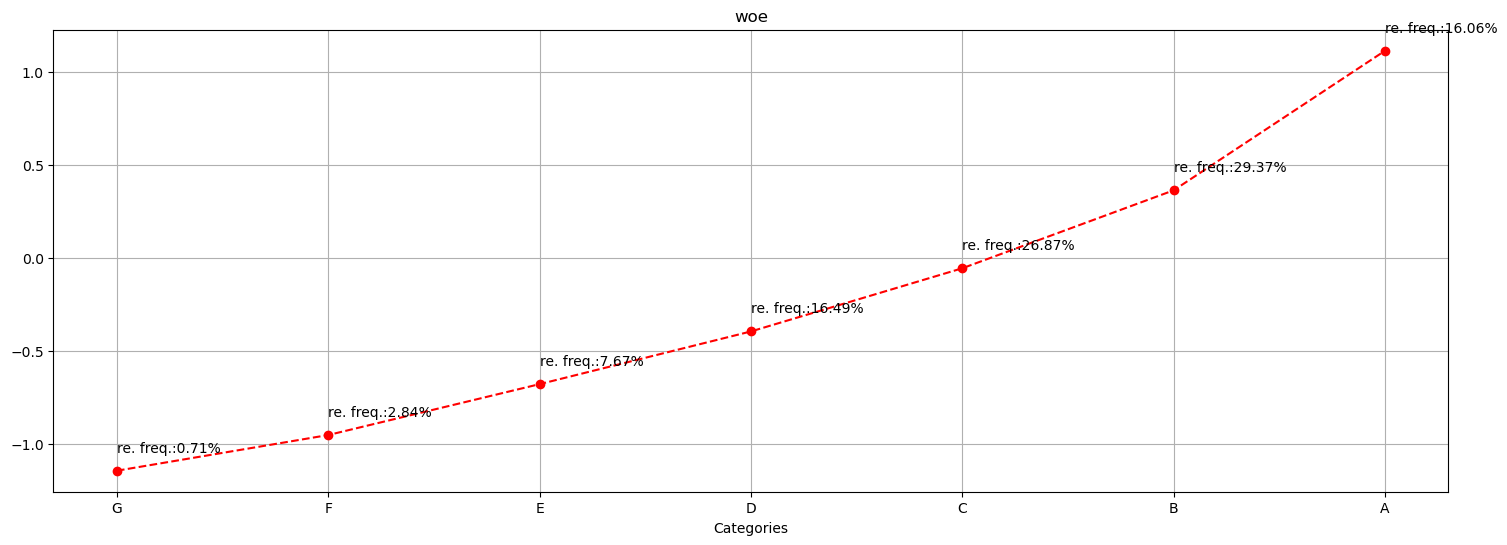

In [183]:
plot_woe(woe_summary.loc['grade', :]['woe'], labels=woe_summary.loc['grade', :]['n_obs_rel'].apply(lambda v: 're. freq.:{:.2%}'.format(v)))